In [3]:
# 1. Importation des bibliothèques
# ===========================
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.impute import KNNImputer


In [7]:
# 2. Chargement des données
# ===========================
path = r"C:/Users/sadal/OneDrive/Desktop/dataPT2.csv"
df = pd.read_csv(path, sep=";", dtype={'ColumnName': 'str'}, low_memory=False)
print("Original Data Head:")
df.head(5)


Original Data Head:


,encounter_id,patient_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,icu_admit_source,...,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem,hospital_death
0,113303,63835,185,77.0,"26,82287414",0,African American,M,"172,7",Accident & Emergency,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular,0
1,100799,68271,6,19.0,"22,89090402",0,Asian,M,"167,6",Accident & Emergency,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic,0
2,97702,25893,77,49.0,"33,85575384",0,Caucasian,F,"167,6",Accident & Emergency,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic,0
3,66955,4599,19,52.0,"36,35802469",0,African American,F,180,Accident & Emergency,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular,0
4,90681,1541,132,83.0,"29,27783633",0,Caucasian,F,"152,4",Accident & Emergency,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular,0


In [5]:
# 3. Prétraitement des données
# ===========================
# Filtrer les variables quantitatives
df_numeric = df.select_dtypes(include=[np.number])
df_numeric = df_numeric.apply(pd.to_numeric, errors='coerce')

# Imputation par la médiane 
imputer = SimpleImputer(strategy='median')
df_numeric = pd.DataFrame(imputer.fit_transform(df_numeric), columns=df_numeric.columns)

# Calculer la moyenne des valeurs manquantes imputées pour chaque variable
imputed_means = df_numeric.mean()
print(f"Moyenne des valeurs imputées pour chaque variable :\n{imputed_means}")
print("-" * 30)

# Filtrage des variables redondantes (corrélation élevée) en fonction d'un seuil de "0,8"
corr_matrix = df_numeric.corr().abs()
threshold = 0.8
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]
df_filtered = df_numeric.drop(columns=to_drop)

Moyenne des valeurs imputées pour chaque variable :
encounter_id                   65622.992016
patient_id                     65529.454460
hospital_id                      105.750672
age                               62.456555
elective_surgery                   0.183652
                                   ...     
immunosuppression                  0.026241
leukemia                           0.007124
lymphoma                           0.004216
solid_tumor_with_metastasis        0.020208
hospital_death                     0.086623
Length: 63, dtype: float64
------------------------------


In [7]:
# 4. Standardisation des données
# ===========================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_filtered)


In [9]:
# 5. Analyse en Composantes Principales (ACP)
# ===========================
pca = PCA()
pca.fit(X_scaled)

# Calculer et afficher la variance expliquée
explained_variance = pca.explained_variance_ratio_

# Choix du nombre optimal de composantes (90% de variance expliquée)
cumsum_variance = np.cumsum(explained_variance)
n_components = np.argmax(cumsum_variance >= 0.90) + 1

# Réduction de dimension avec ACP
pca = PCA(n_components=n_components)
X_pca_reduced = pca.fit_transform(X_scaled)

# Afficher les données après réduction de dimension
print(f"Données après réduction de dimension (forme) : {X_pca_reduced.shape}")
print("-" * 5)

Données après réduction de dimension (forme) : (82542, 31)
-----


In [11]:
# 6. Génération de données synthétiques
# ===========================
def generate_avatar(data, indices):
    avatars = []
    for neighbors in indices:
        weights = np.random.exponential(scale=1.0, size=len(neighbors))
        weights /= np.sum(weights)
        avatar = np.sum(weights[:, None] * data[neighbors], axis=0)
        avatars.append(avatar)
    return np.array(avatars)

# Trouver les k plus proches voisins
def find_knn(data, k=5):
    knn = NearestNeighbors(n_neighbors=k, metric='euclidean')
    knn.fit(data)
    distances, indices = knn.kneighbors(data)
    return distances, indices

k = 5
distances, indices = find_knn(X_pca_reduced, k)

# Générer des avatars à partir des données réduites en PCA
avatars = generate_avatar(X_pca_reduced, indices)

# Afficher les distances moyennes entre voisins
avg_distances = np.mean(distances, axis=1)
print(f"Distances moyennes entre les voisins (k={k}) :\n{avg_distances}")
print("-" * 30)

# Reconstruction des données (inverse PCA transformation)
X_reconstructed = pca.inverse_transform(avatars) 


Distances moyennes entre les voisins (k=5) :
[1.57489417 2.72100168 2.32644295 ... 2.52402214 1.95218454 2.32363722]
------------------------------


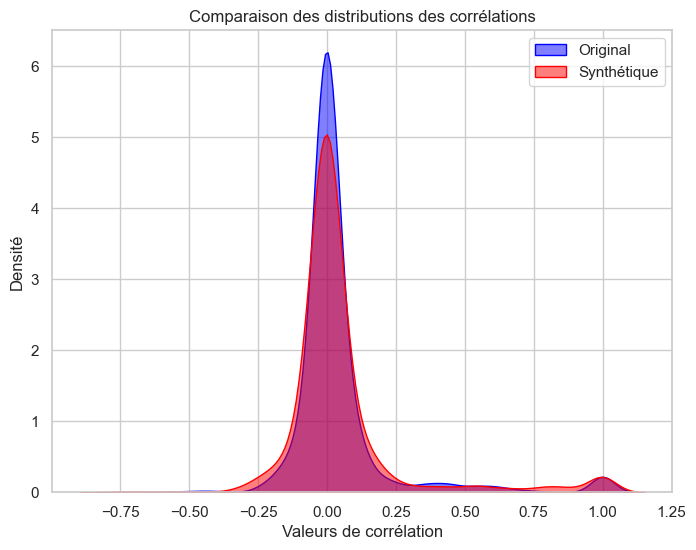

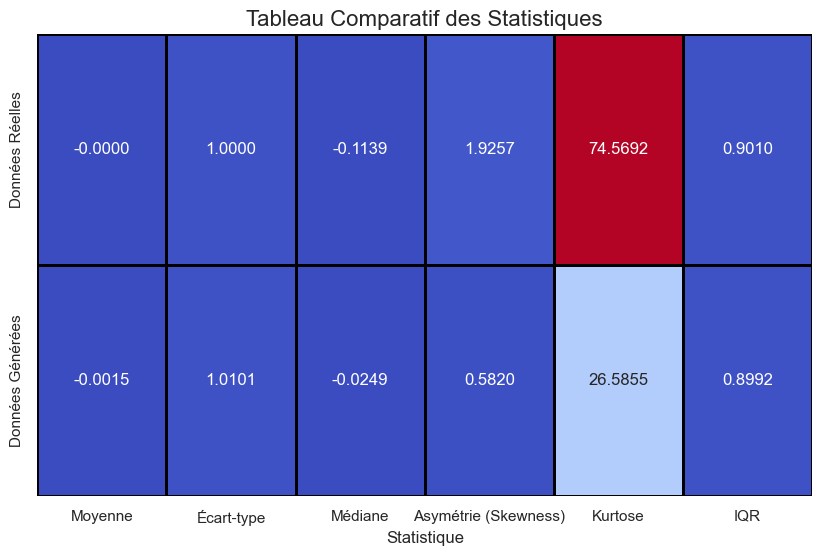

In [31]:
# 7. Évaluation des données synthétiques
# ===========================
# Calcul des corrélations
corr_original = pd.DataFrame(X_scaled, columns=df_filtered.columns).corr()
corr_reconstructed = pd.DataFrame(X_reconstructed, columns=df_filtered.columns).corr()

# Comparaison des distributions des corrélations
plt.figure(figsize=(8, 6))
sns.kdeplot(corr_original.values.flatten(), label="Original", fill=True, color="blue", alpha=0.5)
sns.kdeplot(corr_reconstructed.values.flatten(), label="Synthétique", fill=True, color="red", alpha=0.5)
plt.xlabel("Valeurs de corrélation")
plt.ylabel("Densité")
plt.title("Comparaison des distributions des corrélations")
plt.legend()
plt.show()

# Fonction pour calculer les statistiques descriptives
def calculate_statistics(data):
    data_flat = data.flatten()
    mean = np.mean(data_flat)
    std_dev = np.std(data_flat)
    median = np.median(data_flat)
    skewness = pd.Series(data_flat).skew()
    kurtosis = pd.Series(data_flat).kurt()
    iqr = np.percentile(data_flat, 75) - np.percentile(data_flat, 25)
    return mean, std_dev, median, skewness, kurtosis, iqr

# Calcul des statistiques pour les données réelles
real_stats = calculate_statistics(X_scaled)

# Calcul des statistiques pour les données générées
generated_stats = calculate_statistics(avatars)

# Création du DataFrame sans p-value
data = {
    "Statistique": ["Moyenne", "Écart-type", "Médiane", "Asymétrie (Skewness)", "Kurtose", "IQR"],
    "Données Réelles": [
        real_stats[0], real_stats[1], real_stats[2], real_stats[3], real_stats[4], real_stats[5]
    ],
    "Données Générées": [
        generated_stats[0], generated_stats[1], generated_stats[2], generated_stats[3], generated_stats[4], generated_stats[5]
    ]
}

df = pd.DataFrame(data)

# Appliquer un style au tableau
sns.set(style="whitegrid")

# Visualisation du tableau 
plt.figure(figsize=(10, 6))
sns.heatmap(df.set_index("Statistique").T, annot=True, fmt=".4f", cmap="coolwarm", cbar=False, linewidths=1, linecolor='black', annot_kws={"size": 12}, cbar_kws={'shrink': 0.8})

# Ajouter un titre
plt.title('Tableau Comparatif des Statistiques', fontsize=16)

# Afficher le graphique
plt.show()

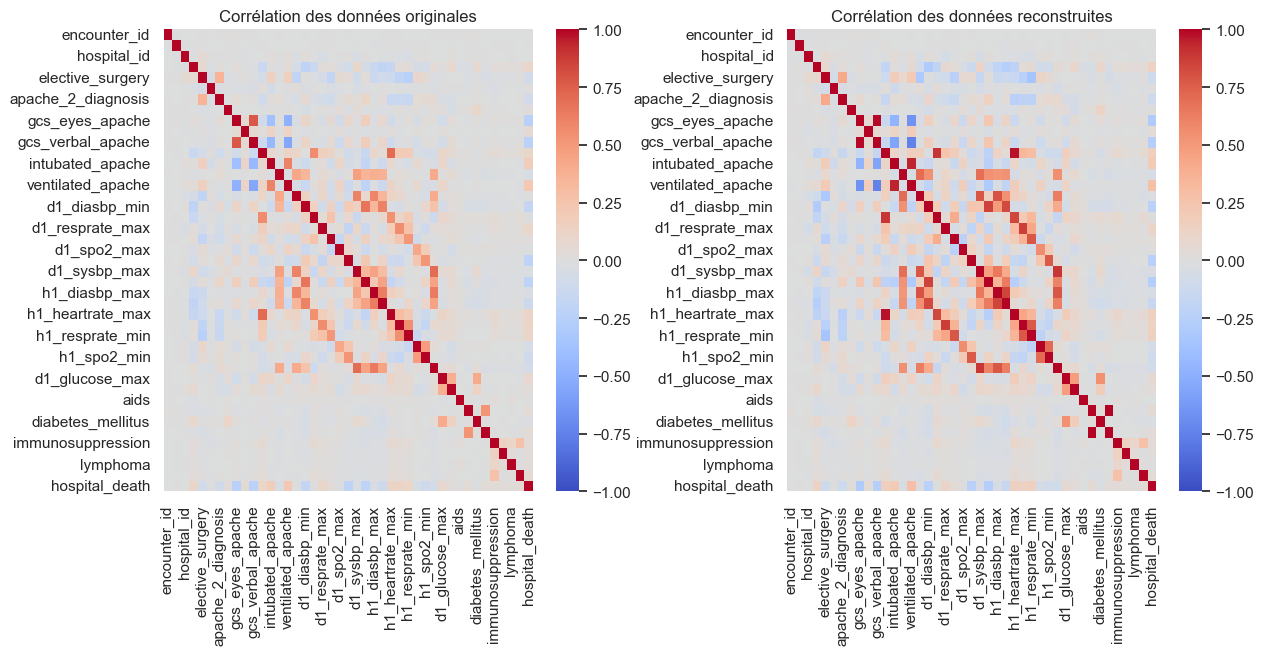

In [33]:
# 8.Visualisation des matrices de corrélation
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(corr_original, ax=ax[0], cmap="coolwarm", vmin=-1, vmax=1)
ax[0].set_title("Corrélation des données originales")

sns.heatmap(corr_reconstructed, ax=ax[1], cmap="coolwarm", vmin=-1, vmax=1)
ax[1].set_title("Corrélation des données reconstruites")

plt.subplots_adjust(wspace=0.35)
plt.show()


Distance moyenne au plus proche voisin (DCR) : 1.3948715597933712
Distance moyenne au ratio du plus proche voisin (NNDR) : 0.7350947896605792


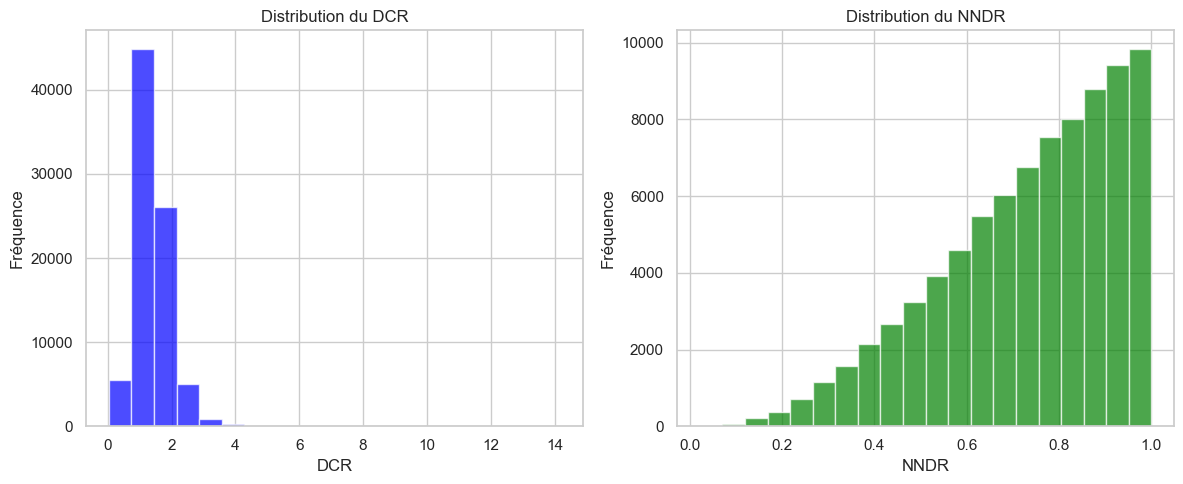

In [17]:
# 9. Calcul des métriques DCR et NNDR
# ===========================
# Calcul du DCR (Distance to Closest Record)
def calculate_dcr(synthetic_data, real_data):
    knn = NearestNeighbors(n_neighbors=1, metric='euclidean')
    knn.fit(real_data)
    distances, _ = knn.kneighbors(synthetic_data)
    return distances.flatten()

dcr = calculate_dcr(avatars, X_pca_reduced) # Compare in PCA space

# Calcul du NNDR (Nearest Neighbor Distance Ratio)
def calculate_nndr(synthetic_data, real_data):
    knn = NearestNeighbors(n_neighbors=2, metric='euclidean')
    knn.fit(real_data)
    distances, _ = knn.kneighbors(synthetic_data)
    nndr = np.divide(distances[:, 0], distances[:, 1],
                     out=np.zeros_like(distances[:, 0]),
                     where=distances[:, 1] != 0)
    return nndr

nndr = calculate_nndr(avatars, X_pca_reduced) # Compare in PCA space

# Afficher les résultats DCR et NNDR
print(f"Distance moyenne au plus proche voisin (DCR) : {np.mean(dcr)}")
print(f"Distance moyenne au ratio du plus proche voisin (NNDR) : {np.mean(nndr)}")

# Visualisation des résultats DCR et NNDR
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(dcr, bins=20, alpha=0.7, color='blue')
plt.xlabel('DCR')
plt.ylabel('Fréquence')
plt.title('Distribution du DCR')

plt.subplot(1, 2, 2)
plt.hist(nndr, bins=20, alpha=0.7, color='green')
plt.xlabel('NNDR')
plt.ylabel('Fréquence')
plt.title('Distribution du NNDR')

plt.tight_layout()
plt.show()
